In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import setup
from src import viral_seq
from src import common

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

# Introduction

Idea: make a new table that joins the viral data with the clinical data in order to make principal component analysis and display the PCs with some ethnical/racial references.

How: the clinical data contains the variable `gilead_id`, representing the pathogen id. The viral data contains an `id` variable. We must simply **join the two DataFrames with this id**.

The clinical and viral data are stored in **binary files** (standard `pickle` package).

In [2]:
VIRAL_DATA_ID = 'id'
CLINICAL_DATA_ID = 'gilead_id'

# Import the two tables tables

Note: we don't want ALL clinical data, only `GT`, `RACE`, `COUNTRY` (+ the id needed for merging). The list of the variables to keep is specified in `src/setup.py`. 

In [3]:
with open(setup.PATH_VIRAL_DATA, 'rb') as file :
    df_viral = pickle.load(file)
with open(setup.PATH_CLINICAL_DATA, 'rb') as file :
    df_clinical = pickle.load(file)
    
# Keep only the relevant clinical data    
df_clinical = df_clinical[ setup.VIRAL_CLINICAL_VARIABLES ]

print("Viral DataFrame shape: {}\nClinical DataFrame shape: {}"
     .format(df_viral.shape, df_clinical.shape))

Viral DataFrame shape: (789, 2007)
Clinical DataFrame shape: (725, 4)


In [4]:
df_clinical.head(1)

,gilead_id,GT,RACE,COUNTRY
0,GS-US-320-0108-1001,B,ASIAN,USA


In [5]:
df_viral.head(1)

gene                      id PC                          ...   X             \
pos                           1  6  7  8  9    10 11 12  ... 143 144    145   
variant                       M  L  C  L  I  V  I  S  C  ...   C   A  S   P   
0        GS-US-174-0149-1884  1  1  1  1  1  0  1  1  1  ...   1   0  1   1   

gene                              
pos     146 147 148 153 154  155  
variant   A   P   C   S   A STOP  
0         1   1   1   1   1    1  

[1 rows x 2007 columns]

# Merge the two tables with the viral IDs

Strategy: we start from `df_viral`, then we use `DataFrame.join` to add the columns of `df_clinical`. However, we must process `df_clinical` first as is as a standard index (while `df_viral has a MultiIndex`). Viral MultiIndex has 3 levels (gene, position, variant), but we only need 2 levels for clinical MultiIndex (clinical, variables), thus we'll let the third level empty.

## Figure out the situation

In [6]:
# Compute the intersection and union between two lists
intersection_ids = list( set(df_viral[VIRAL_DATA_ID]) & set(df_clinical[CLINICAL_DATA_ID]) )
union_ids = list( set(df_viral[VIRAL_DATA_ID]) | set(df_clinical[CLINICAL_DATA_ID]) )
# Compute ids to drop
to_drop = [ index for index in union_ids if index not in intersection_ids ]
print("{} individuals in clinical data\n{} individuals in viral data\n\
-> {} different individuals in total\n-> {} individuals that are common to both datasets"
     .format(df_clinical.shape[0], df_viral.shape[0], len(union_ids), len(intersection_ids)))

725 individuals in clinical data
789 individuals in viral data
-> 790 different individuals in total
-> 724 individuals that are common to both datasets


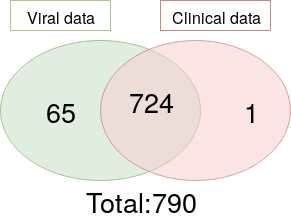

## Preprocessing

### Set new index for clinical data


In [7]:
df_clinical.set_index('gilead_id', inplace=True)
df_clinical.head(1)

,GT,RACE,COUNTRY
gilead_id,,,
GS-US-320-0108-1001,B,ASIAN,USA


### Process the columns of the clinical data

We use the `MultiIndex.from_product` function to construct the MultiIndex. We keep the third level empty.

In [8]:
clinical_cols = pd.MultiIndex.from_product([['clinical'], df_clinical.columns, ['']])
df_clinical.columns = clinical_cols
df_clinical.head(1)

clinical               
                          GT   RACE COUNTRY
                                           
gilead_id                                  
GS-US-320-0108-1001        B  ASIAN     USA

## Merge tables

Note: The table that will be created here will **keep all entries of viral data, without dropping them** (if no corresponding clinical entries are present: it fills with NaN values). That means the entries that are in clinical data but not in viral data were already dropped. Thus we have to **drop the values that are in viral data, but not in clinical data**. See the _"Figure out the situation"_ section above to visualize.

In [9]:
df_merge = df_viral.join(other=df_clinical, on='id')
print("Shape of the merged table:", df_merge.shape)
df_merge.head(1)

Shape of the merged table: (789, 2010)


gene                      id PC                          ...   X              \
pos                           1  6  7  8  9    10 11 12  ... 145 146 147 148   
variant                       M  L  C  L  I  V  I  S  C  ...   P   A   P   C   
0        GS-US-174-0149-1884  1  1  1  1  1  0  1  1  1  ...   1   1   1   1   

gene                 clinical                 
pos     153 154  155       GT   RACE COUNTRY  
variant   S   A STOP                          
0         1   1    1        B  ASIAN     SGP  

[1 rows x 2010 columns]

In [10]:
df_merge.columns

MultiIndex([(      'id',        '',     ''),
            (      'PC',         1,    'M'),
            (      'PC',         6,    'L'),
            (      'PC',         7,    'C'),
            (      'PC',         8,    'L'),
            (      'PC',         9,    'I'),
            (      'PC',         9,    'V'),
            (      'PC',        10,    'I'),
            (      'PC',        11,    'S'),
            (      'PC',        12,    'C'),
            ...
            (       'X',       145,    'P'),
            (       'X',       146,    'A'),
            (       'X',       147,    'P'),
            (       'X',       148,    'C'),
            (       'X',       153,    'S'),
            (       'X',       154,    'A'),
            (       'X',       155, 'STOP'),
            ('clinical',      'GT',     ''),
            ('clinical',    'RACE',     ''),
            ('clinical', 'COUNTRY',     '')],
           names=['gene', 'pos', 'variant'], length=2010)

**The index structure is not really meaningful**, since the MultiIndex was first created for the purpose of manipulating the genes/positions/variants. However, I **assume that it is a reasonable** way of doing, since this does not make me unable to do any computation that I need (yet...).

## Drop the values belonging to a single table

This is a very important step. Compare with the counts done above (*Figure out the situation*) to compare the expected shape of the table. 

As said above, here we need to drop the values that are in viral data (i.e. already in the table) whenever they do not appear in the clinical data. Mathematically, we are looking for the **complement of the intersection, minus the clinical entries**.

*Note: to avoid struggling for absolutely nothing, note that the `in` keyword must be used with the `values` of the Series !!!*

In [15]:
to_drop = [i for i in union_ids if i not in df_clinical.index.values]
len(to_drop)

65

In [16]:
# Get the corresponding IDs of the data structure (within the integer range)
ids_to_drop = df_merge[df_merge[VIRAL_DATA_ID].isin(to_drop)].index
df_merge.drop(ids_to_drop, axis=0, inplace=True)
print("{} individuals were dropped.".format(len(ids_to_drop)), "Shape =", df_merge.shape)

65 individuals were dropped. Shape = (724, 2010)


# Principal component analysis 

Here we want to do PC again, and cross the pathogen entries with some of their host's clinical data (race, ethnicity, country, ...).

Strategy: provide the PCA function a transposed table (with the genes only, no ids, no clinical data). Then display it with the corresponding clinical data.

In [17]:
# To exclude all but the genes
df_merge.columns.levels

FrozenList([['PC', 'Pol', 'S', 'X', 'clinical', 'id'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...], ['', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'STOP', 'T', 'V', 'W', 'Y']])

In [18]:
# Compute the PCs
gene_related = ['PC', 'Pol', 'S', 'X']
pcs = viral_seq.pca_impute(df=df_merge[gene_related].transpose(), n_components=20,
                           impute_strategy='most_frequent')

In [19]:
# Define plotting parameters
pc_plot_height = 2.3
figsize=(4,4)
bbox_to_anchor=(1.2,1.2)
n_plots=2
scaled_only=True
singular_values=False

<Figure size 432x288 with 0 Axes>

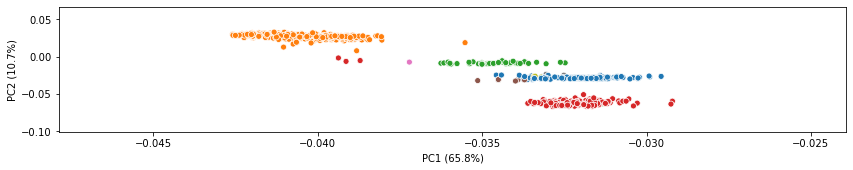

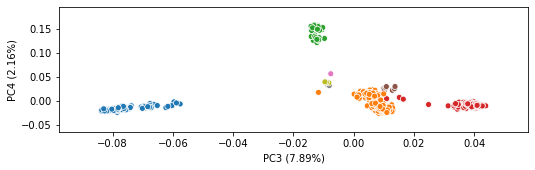

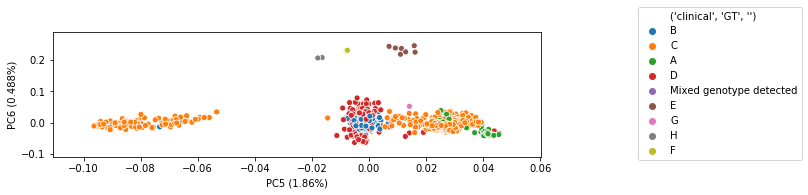

In [20]:
common.plot_pca(pcs, pc_plot_height=pc_plot_height, figsize=figsize, 
                bbox_to_anchor=bbox_to_anchor,
                n_plots=3, scaled_only=scaled_only, hue=df_merge[('clinical', 'GT', '')],
               singular_values=singular_values)

<Figure size 432x288 with 0 Axes>

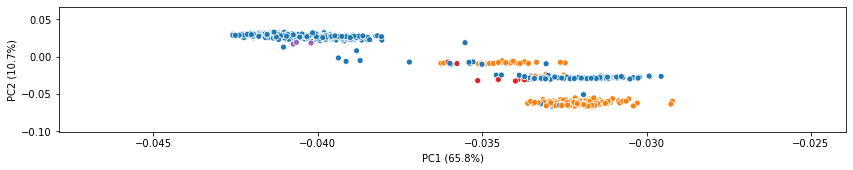

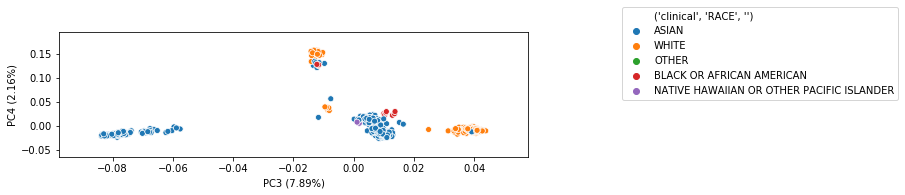

In [21]:
common.plot_pca(pcs, pc_plot_height=pc_plot_height, figsize=figsize, 
                bbox_to_anchor=bbox_to_anchor,
                n_plots=n_plots, scaled_only=scaled_only, hue=df_merge[('clinical', 'RACE', '')],
               singular_values=singular_values)

<Figure size 432x288 with 0 Axes>

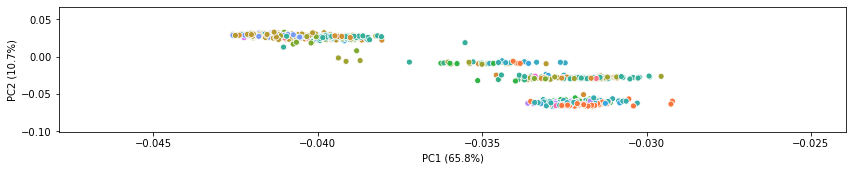

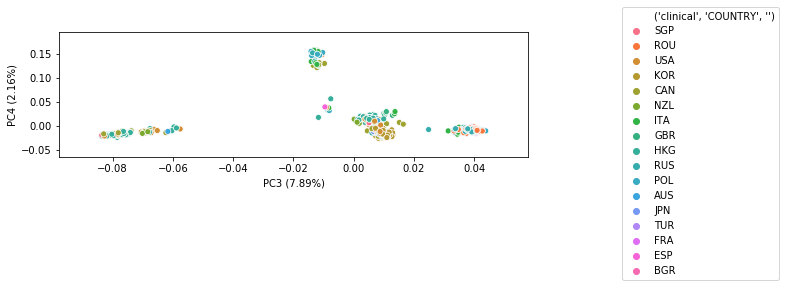

In [22]:
common.plot_pca(pcs, pc_plot_height=pc_plot_height, figsize=figsize, 
                bbox_to_anchor=bbox_to_anchor,
                n_plots=n_plots, scaled_only=scaled_only, hue=df_merge[('clinical', 'COUNTRY', '')],
               singular_values=singular_values)